# Search: Solving a Maze Using a Goal-based Agent

Student Name: Phan Thanh Thịnh

I have used the following AI tools: ChatGPT

I understand that my submission needs to be my own work: PPT

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [2]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [4]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

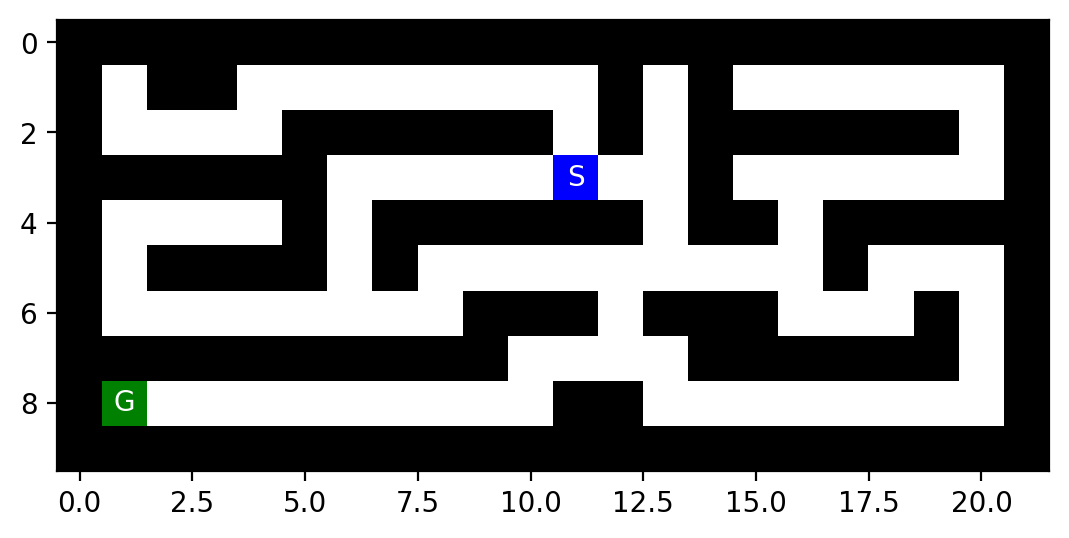

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [6]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [7]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [6]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

In [14]:
# Cell: parse_mazes_and_report.py
import numpy as np
import os
from collections import deque


maze_files = [
    "small_maze.txt",
    "medium_maze.txt",
    "large_maze.txt",
    "open_maze.txt",
    # "wall_maze.txt", kh có file
    "loops_maze.txt",
    "empty_maze.txt",
    "empty_maze_2.txt"
]

def read_maze(path):
    """Đọc maze từ file, trả về list of strings (không có newline cuối)."""
    with open(path, "r", encoding="utf-8") as f:
        lines = [line.rstrip("\n") for line in f.readlines() if line.rstrip("\n")!=""]
    return lines
    # Đọc từng dòng bỏ dòng trống tra về list of strings

def maze_to_array(lines):
    """Chuyển list of strings -> np.array ký tự hình chữ nhật."""
    maxlen = max(len(line) for line in lines)
    arr = np.array([list(line.ljust(maxlen, "#")) for line in lines])  
    # Chuẩn hoá tất cả các dòng cho bằng độ dài maxlen, nếu thiếu thì thêm ký tự # (tường) vào cuối.
    return arr

def find_positions(arr):
    """Tìm S và G và các ô free (not '#')."""
    coords_S = list(zip(*np.where(arr == 'S')))
    coords_G = list(zip(*np.where(arr == 'G')))
    free_coords = list(zip(*np.where(arr != '#')))  # tất cả ô khác '#'
    S = coords_S[0] if coords_S else None
    G = coords_G[0] if coords_G else None
    return S, G, set(free_coords)
# Ví dụ: S = (0,0), G = (1,2), free_coords = {(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)}

def valid_moves(arr, pos):
    """Trả về danh sách hành động hợp lệ (định dạng: ('Up', newpos))"""
    r, c = pos # current row, col
    moves = []
    candidates = [
        ("Up", (r-1, c)),
        ("Down", (r+1, c)),
        ("Left", (r, c-1)),
        ("Right", (r, c+1))
    ]
    nrows, ncols = arr.shape
    for act, (rr, cc) in candidates:
        if 0 <= rr < nrows and 0 <= cc < ncols and arr[rr,cc] != '#':
            moves.append((act, (rr,cc)))
    return moves

def manhattan(a,b):
    if a is None or b is None:
        return None
    return abs(a[0]-b[0]) + abs(a[1]-b[1])
# Tính khoảng cách Manhattan giữa 2 tọa độ


def average_branching(arr, free_coords):
    total = 0
    for pos in free_coords:
        total += len(valid_moves(arr, pos)) #Với mỗi ô trống (free_coords), đếm số bước đi hợp lệ
    return total / len(free_coords) if free_coords else 0 #Lấy trung bình → cho biết trung bình mỗi ô có bao nhiêu hướng đi được

def bfs_shortest_length(arr, S, G, free_coords):
    """Nếu có đường đi, trả về length (số bước). Nếu không, trả None."""
    if S is None or G is None:
        return None
    visited = set() # các ô đã đi qua 
    q = deque() 
    q.append((S, 0)) # bắt đầu từ điểm S với khoảng cách 0.
    visited.add(S)
    while q:
        pos, d = q.popleft() # Lấy phần tử đầu tiên trong hàng đợi ra để xử lý
        if pos == G:
            return d
        for _, npos in valid_moves(arr, pos): # duyệt các ô láng giềng nếu ch thăm thì đánh dấu và thêm vào hàng đợi
            if npos not in visited:
                visited.add(npos)
                q.append((npos, d+1))
    return None

# Chạy phân tích cho từng file:
report = []
for fname in maze_files:
    if not os.path.exists(fname):
        print(f"[WARN] File '{fname}' không tồn tại trong thư mục hiện tại. Bỏ qua.")
        continue
    lines = read_maze(fname)
    arr = maze_to_array(lines)
    S, G, free = find_positions(arr)
    rows, cols = arr.shape
    N_free = len(free)
    b_avg = average_branching(arr, free) if N_free>0 else 0
    d_man = manhattan(S,G)
    d_bfs = bfs_shortest_length(arr, S, G, free)  # thực tế là shortest path length
    report.append({
        "file": fname,
        "rows": rows,
        "cols": cols,
        "S": S,
        "G": G,
        "N_free": N_free,
        "b_avg": round(b_avg,3),
        "manhattan": d_man,
        "shortest_length_BFS": d_bfs
    })

# In báo cáo tóm tắt
import pandas as pd
df = pd.DataFrame(report)
if not df.empty:
    display(df)
else:
    print("Không có file mê cung nào được tìm thấy/đọc được.")


,file,rows,cols,S,G,N_free,b_avg,manhattan,shortest_length_BFS
0,small_maze.txt,10,22,"(3, 11)","(8, 1)",220,3.709,15,15
1,medium_maze.txt,18,36,"(1, 34)","(16, 1)",648,3.833,48,48
2,large_maze.txt,37,37,"(35, 35)","(35, 1)",1369,3.892,34,34
3,open_maze.txt,23,37,"(1, 35)","(21, 1)",851,3.859,54,54
4,loops_maze.txt,12,12,"(10, 1)","(1, 1)",144,3.667,9,9
5,empty_maze.txt,12,12,"(9, 2)","(2, 9)",144,3.667,14,14
6,empty_maze_2.txt,12,12,"(2, 9)","(9, 2)",144,3.667,14,14


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
import numpy as np
from collections import deque
import pandas as pd

# ----------- HÀM HỖ TRỢ -------------
def count_free(arr):
    return np.sum(arr != '#')

def neighbors(arr, pos):
    r, c = pos
    cand = [(r-1, c), (r+1, c), (r, c-1), (r, c+1)]
    out = []
    R, C = arr.shape
    for rr, cc in cand:
        if 0 <= rr < R and 0 <= cc < C and arr[rr, cc] != '#':
            out.append((rr, cc))
    return out

def compute_b_avg_and_bmax(arr):
    free_positions = list(zip(*np.where(arr != '#')))
    degs = [len(neighbors(arr, pos)) for pos in free_positions]
    b_avg = sum(degs) / len(degs) if degs else 0
    b_max = max(degs) if degs else 0
    return b_avg, b_max

def bfs_shortest(arr, S, G):
    if S is None or G is None: 
        return None
    q = deque([(S, 0)])
    vis = set([S])
    while q:
        pos, d = q.popleft()
        if pos == G:
            return d
        for npos in neighbors(arr, pos):
            if npos not in vis:
                vis.add(npos)
                q.append((npos, d+1))
    return None  # no path

def analyze_maze(file):
    # đọc file và parse
    with open(file, "r") as f:
        maze_str = [line.rstrip("\n") for line in f if line.strip()]
    arr = np.array([list(row) for row in maze_str])

    # tìm S, G
    S = tuple(np.argwhere(arr == 'S')[0]) if np.any(arr == 'S') else None
    G = tuple(np.argwhere(arr == 'G')[0]) if np.any(arr == 'G') else None

    # tính toán
    n = count_free(arr)
    d = bfs_shortest(arr, S, G)
    m_upper = n - 1
    b_avg, b_max = compute_b_avg_and_bmax(arr)

    return {
        "Maze": file,
        "Size": arr.shape,
        "n (states)": n,
        "d (opt depth)": d,
        "m (max depth)": m_upper,
        "b_avg": round(b_avg, 2),
        "b_max": b_max
    }

maze_files = [
    "small_maze.txt",
    "medium_maze.txt",
    "large_maze.txt",
    "open_maze.txt",
    # "wall_maze.txt", # không có file này
    "loops_maze.txt",
    "empty_maze.txt",
    "empty_maze_2.txt"
]

# ----------- PHÂN TÍCH TẤT CẢ MAZE -------------
results = []
for file in maze_files:
    try:
        results.append(analyze_maze(file))
    except Exception as e:
        results.append({"Maze": file, "Error": str(e)})

# in bảng kết quả
df = pd.DataFrame(results)
print(df)


               Maze      Size  n (states)  d (opt depth)  m (max depth)  \
0    small_maze.txt  (10, 22)         220             15            219   
1   medium_maze.txt  (18, 36)         648             48            647   
2    large_maze.txt  (37, 37)        1369             34           1368   
3     open_maze.txt  (23, 37)         851             54            850   
4    loops_maze.txt  (12, 12)         144              9            143   
5    empty_maze.txt  (12, 12)         144             14            143   
6  empty_maze_2.txt  (12, 12)         144             14            143   

   b_avg  b_max  
0   3.71      4  
1   3.83      4  
2   3.89      4  
3   3.86      4  
4   3.67      4  
5   3.67      4  
6   3.67      4  


## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [26]:
from collections import deque

# --------------------
# Breadth-First Search
# --------------------
def breadth_first_search(start, goal, maze):
    """
    BFS: Tìm đường từ start đến goal trong maze.
    - start, goal: tuple (row, col)
    - maze: numpy array chứa bản đồ
    """
    root = Node(start, None, None, 0)     # node gốc (start), chưa có cha, cost=0
    if start == goal:
        return root.get_path_from_root(), 0, 0, 1  # nếu start==goal thì trả về luôn
    
    frontier = deque([root])      # queue làm frontier (các node chờ duyệt)
    reached = {start: root}       # dictionary lưu các state đã thăm
    nodes_expanded = 0            # số node đã mở rộng
    max_frontier_size = 1         # kích thước frontier lớn nhất )
    max_depth = 0                 # độ sâu lớn nhất đạt được

    while frontier:               # còn node trong frontier thì tiếp tục duyệt
        node = frontier.popleft() # lấy node đầu tiên trong queue (BFS)
        nodes_expanded += 1       # đếm số node đã mở rộng
        max_depth = max(max_depth, node.cost)  # cập nhật độ sâu lớn nhất

        for npos in neighbors(maze, node.pos):   # duyệt các neighbor (láng giềng)
            if npos not in reached:              # nếu chưa thăm
                child = Node(npos, node, None, node.cost + 1) # tạo node con
                if npos == goal:                 
                    return child.get_path_from_root(), nodes_expanded, max_depth, max_frontier_size
                reached[npos] = child            # đánh dấu đã thăm
                frontier.append(child)           # thêm vào frontier
        max_frontier_size = max(max_frontier_size, len(frontier)) # cập nhật frontier lớn nhất
    
    return None, nodes_expanded, max_depth, max_frontier_size   # không tìm thấy đường


# --------------------
# Depth-First Search
# --------------------
def depth_first_search(start, goal, maze, max_depth_limit=10000):
    """
    DFS: Tìm đường từ start đến goal trong maze.
    - Không dùng reached (visited) toàn cục => tiết kiệm bộ nhớ
    - Có kiểm tra cycle để tránh vòng lặp vô hạn
    """
    root = Node(start, None, None, 0)                 # node gốc
    stack = [(root, set([start]))]                    # stack lưu (node, tập các state trong path)
    nodes_expanded = 0                                # số node mở rộng
    max_frontier_size = 1                             # frontier lớn nhất
    max_depth = 0                                     # độ sâu lớn nhất

    while stack:                                      # còn node trong stack thì tiếp tục
        node, path_set = stack.pop()                  # lấy node cuối (DFS: LIFO)
        nodes_expanded += 1                           
        max_depth = max(max_depth, node.cost)         

        if node.pos == goal:                        
            return node.get_path_from_root(), nodes_expanded, max_depth, max_frontier_size

        if node.cost < max_depth_limit:               # kiểm soát độ sâu (tránh đi quá sâu)
            for npos in neighbors(maze, node.pos):  
                if npos not in path_set:              # nếu chưa đi trong path hiện tại (tránh cycle)
                    child = Node(npos, node, None, node.cost + 1)
                    new_path_set = set(path_set)      # copy lại path_set
                    new_path_set.add(npos)            # thêm npos vào path
                    stack.append((child, new_path_set)) # thêm node con vào stack
        max_frontier_size = max(max_frontier_size, len(stack)) # cập nhật frontier lớn nhất

    return None, nodes_expanded, max_depth, max_frontier_size   # không tìm thấy đường


In [27]:
# dịnh nghĩa node
class Node:
    def __init__(self, pos, parent=None, action=None, cost=0):
        self.pos = tuple(pos)    # vị trí (row, col)
        self.parent = parent     # tham chiếu đến node cha
        self.action = action     # hành động để đi từ cha -> node này
        self.cost = cost         # độ sâu hoặc g(n)

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """Trả về đường đi từ gốc tới node hiện tại."""
        node = self
        path = [node.pos]
        
        while node.parent is not None:
            node = node.parent
            path.append(node.pos)
        
        path.reverse()
        return path


In [28]:
import numpy as np
import time

def load_maze(filename):
    """Đọc maze từ file txt, trả về (maze, start, goal)."""
    with open(filename) as f:
        maze_str = [line.strip() for line in f if line.strip()]
    maze = np.array([list(row) for row in maze_str])
    start = tuple(np.argwhere(maze == 'S')[0])
    goal = tuple(np.argwhere(maze == 'G')[0])
    return maze, start, goal

# danh sách file maze
maze_files = [
    "small_maze.txt",
    "medium_maze.txt",
    "large_maze.txt",
    "open_maze.txt",
    # "wall_maze.txt", # không có file này
    "loops_maze.txt",
    "empty_maze.txt",
    "empty_maze_2.txt"
]

# chạy BFS và DFS cho từng maze
for maze_file in maze_files:
    print(f"\n=== Maze: {maze_file} ===")
    maze, S, G = load_maze(maze_file)

    # --- BFS ---
    t0 = time.time()
    path_bfs, exp_bfs, depth_bfs, frontier_bfs = breadth_first_search(S, G, maze)
    t1 = time.time()

    print("BFS:")
    print("  Path length      =", len(path_bfs)-1 if path_bfs else None)
    print("  Path cost        =", len(path_bfs)-1 if path_bfs else None)  # path cost = số bước
    print("  Nodes expanded   =", exp_bfs)
    print("  Max depth        =", depth_bfs)
    print("  Max frontier size=", frontier_bfs)
    print("  Runtime (s)      =", round(t1-t0, 5))

    # --- DFS ---
    t0 = time.time()
    path_dfs, exp_dfs, depth_dfs, frontier_dfs = depth_first_search(S, G, maze)
    t1 = time.time()

    print("DFS:")
    print("  Path length      =", len(path_dfs)-1 if path_dfs else None)
    print("  Path cost        =", len(path_dfs)-1 if path_dfs else None)
    print("  Nodes expanded   =", exp_dfs)
    print("  Max depth        =", depth_dfs)
    print("  Max frontier size=", frontier_dfs)
    print("  Runtime (s)      =", round(t1-t0, 5))



=== Maze: small_maze.txt ===
BFS:
  Path length      = 15
  Path cost        = 15
  Nodes expanded   = 207
  Max depth        = 14
  Max frontier size= 20
  Runtime (s)      = 0.00246
DFS:
  Path length      = 119
  Path cost        = 119
  Nodes expanded   = 120
  Max depth        = 119
  Max frontier size= 138
  Runtime (s)      = 0.00132

=== Maze: medium_maze.txt ===
BFS:
  Path length      = 48
  Path cost        = 48
  Nodes expanded   = 640
  Max depth        = 47
  Max frontier size= 20
  Runtime (s)      = 0.00329
DFS:
  Path length      = 540
  Path cost        = 540
  Nodes expanded   = 541
  Max depth        = 540
  Max frontier size= 563
  Runtime (s)      = 0.01077

=== Maze: large_maze.txt ===
BFS:
  Path length      = 34
  Path cost        = 34
  Nodes expanded   = 662
  Max depth        = 33
  Max frontier size= 38
  Runtime (s)      = 0.0035
DFS:
  Path length      = 40
  Path cost        = 40
  Nodes expanded   = 41
  Max depth        = 40
  Max frontier size= 40
  

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

Nếu BFS không có reached, thì mỗi lần gặp lại một trạng thái cũ, nó vẫn sẽ được đưa vào frontier để mở rộng lại. Kết quả là số lượng node sẽ tăng lên cực nhanh (do lặp lại liên tục), khiến BFS tiêu tốn rất nhiều bộ nhớ và thời gian, thậm chí chạy mãi không kết thúc trong môi trường có chu trình.

Khi DFS mở rộng một node mới, nó sẽ kiểm tra xem node đó có xuất hiện trong đường đi từ gốc đến node hiện tại hay chưa. Nếu có thì bỏ qua, tránh quay lại một trạng thái đã nằm trong cùng một nhánh.
Cách làm này giúp DFS tránh vòng lặp trực tiếp (quay lại cha hoặc tổ tiên gần nhất), nhưng DFS vẫn có thể duyệt nhiều nhánh khác nhau dẫn đến cùng một trạng thái (ví dụ đi vòng qua một đường khác). Do không có reached, các trạng thái lặp từ nhánh khác nhau vẫn được duyệt lại → dẫn đến nhiều node thừa, nhưng vẫn đảm bảo thuật toán không bị kẹt trong vòng lặp vô hạn.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

    BFS (Breadth-First Search):

BFS trong cài đặt của mình là hoàn chỉnh (complete) vì nếu có lời giải thì chắc chắn tìm thấy (do duyệt tuần tự theo độ sâu tăng dần).

BFS cũng là tối ưu (optimal) với chi phí đường đi bằng nhau (mỗi bước đi có chi phí = 1), vì nó luôn tìm được đường đi ngắn nhất từ start → goal.

    DFS (Depth-First Search, không dùng reached, chỉ cycle checking):

DFS không hoàn chỉnh trong môi trường vô hạn hoặc đồ thị có nhiều chu trình phức tạp (nếu không có cycle checking, nó có thể lặp vô tận). Với cycle checking, DFS sẽ tránh được lặp trực tiếp nhưng vẫn có nguy cơ duyệt nhiều trạng thái trùng nhau qua nhánh khác → không đảm bảo sẽ tìm được lời giải trong mọi trường hợp.

DFS cũng không tối ưu, vì nó có thể tìm thấy một lời giải nhưng không đảm bảo là đường đi ngắn nhất.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [ ]:
import heapq
import numpy as np
import itertools
import heapq

def manhattan_distance(a, b):
    """Hàm heuristic: khoảng cách Manhattan giữa 2 điểm (row, col)."""
    return abs(a[0] - b[0]) + abs(a[1] - b[1])



def greedy_best_first_search(start, goal, maze):
    root = Node(start, None, None, 0)
    counter = itertools.count()  # Bộ đếm tăng dần
    
    frontier = [(manhattan_distance(start, goal), next(counter), root)]
    heapq.heapify(frontier)  # dùng min-heap (ưu tiên node có h (chi phí ước lượng)nhỏ nhất)
    
    reached = {start: root}  # lưu các trạng thái đã thăm
    expanded, max_frontier = 0, 1
    
    while frontier:
        _, _, node = heapq.heappop(frontier)  # lấy node có h nhỏ nhất ra
        expanded += 1  # tăng số node đã mở rộng
        
        if node.pos == goal:  # nếu đến đích thì trả về kết quả
            return node.get_path_from_root(), expanded, node.cost, max_frontier
        
        # duyệt 4 hướng (Bắc, Nam, Tây, Đông)
        for dr, dc, action in [(-1,0,"N"),(1,0,"S"),(0,-1,"W"),(0,1,"E")]:
            nr, nc = node.pos[0] + dr, node.pos[1] + dc
            # kiểm tra tọa độ hợp lệ và không phải tường
            if 0 <= nr < maze.shape[0] and 0 <= nc < maze.shape[1] and maze[nr,nc] != '#':
                child_pos = (nr, nc)
                if child_pos not in reached:  # chưa thăm
                    child = Node(child_pos, node, action, node.cost+1)
                    reached[child_pos] = child
                    # greedy best-first chỉ xét h(n)
                    heapq.heappush(frontier, (manhattan_distance(child_pos, goal), next(counter), child))
        
        max_frontier = max(max_frontier, len(frontier))  # cập nhật kích thước frontier lớn nhất
    
    return None, expanded, None, max_frontier  # không tìm thấy đường



def a_star_search(start, goal, maze):
    root = Node(start, None, None, 0)
    counter = itertools.count()
    
    frontier = [(manhattan_distance(start, goal), next(counter), root)]
    heapq.heapify(frontier)  # min-heap, lưu (f, id, node)
    
    reached = {start: root}  # dictionary lưu node đã thấy
    expanded, max_frontier = 0, 1
    
    while frontier:
        _, _, node = heapq.heappop(frontier)  # lấy node có f nhỏ nhất ra
        expanded += 1
        
        if node.pos == goal:  # nếu tới đích thì trả về đường đi
            return node.get_path_from_root(), expanded, node.cost, max_frontier
        
        # xét 4 hướng
        for dr, dc, action in [(-1,0,"N"), (1,0,"S"), (0,-1,"W"), (0,1,"E")]:
            nr, nc = node.pos[0] + dr, node.pos[1] + dc
            if 0 <= nr < maze.shape[0] and 0 <= nc < maze.shape[1] and maze[nr,nc] != '#':
                child_pos = (nr, nc)
                new_cost = node.cost + 1  # g(n) tăng thêm 1 bước
                
                # nếu chưa thăm hoặc tìm được đường tốt hơn
                if child_pos not in reached or new_cost < reached[child_pos].cost:
                    child = Node(child_pos, node, action, new_cost)
                    reached[child_pos] = child
                    f_score = new_cost + manhattan_distance(child_pos, goal)  # f(n) = g(n) + h(n)
                    heapq.heappush(frontier, (f_score, next(counter), child))
        
        max_frontier = max(max_frontier, len(frontier))  # cập nhật kích thước frontier lớn nhất
    
    return None, expanded, None, max_frontier  # không tìm thấy đường

In [61]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # vị trí: (row, col)
        self.parent = parent     # node cha
        self.action = action     # hành động (N, S, W, E)
        self.cost = cost         # g(n): độ sâu hoặc chi phí

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """Trả về danh sách node từ gốc -> node hiện tại."""
        node = self
        path = [node]
    
        while node.parent is not None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        return path


In [62]:
for filename in maze_files:
    print("="*40)
    print(f"Maze: {filename}")
    maze, S, G = load_maze(filename)   # Lấy maze + Start + Goal

    # --- GBFS ---
    path_gbfs, exp_gbfs, depth_gbfs, frontier_gbfs = greedy_best_first_search(S, G, maze)
    print("GBFS:")
    print(f"  Path length: {len(path_gbfs) if path_gbfs else None}")
    print(f"  Path cost: {depth_gbfs}")
    print(f"  Nodes expanded: {exp_gbfs}")
    print(f"  Max frontier size: {frontier_gbfs}")

    # --- A* ---
    path_astar, exp_astar, depth_astar, frontier_astar = a_star_search(S, G, maze)
    print("A*:")
    print(f"  Path length: {len(path_astar) if path_astar else None}")
    print(f"  Path cost: {depth_astar}")
    print(f"  Nodes expanded: {exp_astar}")
    print(f"  Max frontier size: {frontier_astar}")


Maze: small_maze.txt
GBFS:
  Path length: 16
  Path cost: 15
  Nodes expanded: 16
  Max frontier size: 31
A*:
  Path length: 16
  Path cost: 15
  Nodes expanded: 66
  Max frontier size: 33
Maze: medium_maze.txt
GBFS:
  Path length: 49
  Path cost: 48
  Nodes expanded: 49
  Max frontier size: 97
A*:
  Path length: 49
  Path cost: 48
  Nodes expanded: 544
  Max frontier size: 99
Maze: large_maze.txt
GBFS:
  Path length: 35
  Path cost: 34
  Nodes expanded: 35
  Max frontier size: 70
A*:
  Path length: 35
  Path cost: 34
  Nodes expanded: 35
  Max frontier size: 70
Maze: open_maze.txt
GBFS:
  Path length: 55
  Path cost: 54
  Nodes expanded: 55
  Max frontier size: 109
A*:
  Path length: 55
  Path cost: 54
  Nodes expanded: 735
  Max frontier size: 111
Maze: loops_maze.txt
GBFS:
  Path length: 10
  Path cost: 9
  Nodes expanded: 10
  Max frontier size: 20
A*:
  Path length: 10
  Path cost: 9
  Nodes expanded: 10
  Max frontier size: 20
Maze: empty_maze.txt
GBFS:
  Path length: 15
  Path c

Are your implementations complete and optimal? What is the time and space complexity?

    Greedy Best-First Search (GBFS)

Đầy đủ:

GBFS không đảm bảo đầy đủ nếu có chu trình (loop) hoặc mê cung vô hạn, vì nó chỉ chọn nút “gần goal nhất” theo heuristic mà không quan tâm đến chi phí đường đi.

Trong bài toán mê cung hữu hạn và có kiểm tra visited/reached, nó đầy đủ (sẽ tìm ra đường đi nếu có).

Tối ưu:

GBFS không tối ưu vì chỉ chọn đường đi “trông có vẻ gần” goal nhất, có thể đi vòng vèo hơn so với đường đi ngắn nhất.

    A* Search

Đầy đủ:

Nếu heuristic admissible (không bao giờ đánh giá quá cao chi phí thật sự) thì A* luôn đầy đủ trên không gian hữu hạn.

Heuristic Manhattan trong mê cung (chỉ di chuyển 4 hướng) là admissible → đảm bảo tìm thấy lời giải nếu tồn tại.

Tối ưu:

A* sẽ tối ưu (tìm đường đi ngắn nhất) khi heuristic admissible và consistent.

Manhattan distance vừa admissible vừa consistent → A* của bạn tối ưu.

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [14]:
# Add code

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [15]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [16]:
# Add discussion

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [17]:
# Your code/answer goes here

### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [18]:
# Your code/answer goes here

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [19]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [20]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [21]:
# Your code/answer goes here